In [1]:
from src.data import save_imgs_list_2npy
import os
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
from os import listdir
from os.path import isfile, join
from datetime import datetime
from datetime import timedelta
import csv

from src import data, evaluate, model, preprocessing, visualization
from src.lib import utils
from src.data import MontevideoDataset

In [2]:
utils.image_sequence_generator_folders(path='data/mvd/val',
                                 in_channel=3,
                                 out_channel=1,
                                 min_time_diff=5,
                                 max_time_diff=15,
                                 csv_path='data/mvd/val_sequence_wo_night.csv')

## Model Trainning

In [1]:
#from torch.utils.tensorboard import SummaryWriter
import torch
from torch.utils.data import DataLoader, random_split
from torch import optim
import torch.nn as nn
#from piqa import SSIM , MS_SSIM
from src.dl_models.unet import UNet
#from tqdm import tqdm
import random

In [2]:
#SETUP
USE_GPU = True
dtype = torch.float32 # we will be using float throughout this tutorial
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cpu


In [6]:
#torch.cuda.empty_cache()
model = UNet(n_channels=3,n_classes=1,bilinear=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001,betas = (0.9,0.999),eps =1e-08, weight_decay=0 ,amsgrad=False)
criterion = nn.MSELoss()

epochs=1
batch_size = 10
#eval_data = 30

train_mvd = MontevideoFoldersDataset(path = 'data/mvd/train/' , path_sequence_csv = 'data/mvd/train_sequences.csv',
                                      in_channel = 3,out_channel=1, shuffle = False)

# val_mvd = MontevideoFoldersDataset(path = 'data/mvd/validation/' , path_sequence_csv = 'data/mvd/val_sequences.csv',
#                                     in_channel = 3,out_channel=1, shuffle = False)

train_dataloader = DataLoader(train_mvd, batch_size=batch_size, shuffle=False, num_workers=2)
#val_dataloader = DataLoader(val_mvd, batch_size=batch_size, shuffle=False, num_workers=2)
  
print_every = 10

with open('reports/test_les.csv', 'w', encoding='UTF8',newline='') as f:
  writer = csv.writer(f)

  start = time.perf_counter()
  for id, (in_frames,out_frames) in enumerate(train_dataloader):
    model.train(True) #put model in trainning mode
    in_frames = in_frames.to(device, dtype=torch.float32)
    out_frames = out_frames.to(device, dtype=torch.float32)

    frames_pred = model(in_frames)
    loss = criterion(frames_pred, out_frames)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if id % print_every == 0:
      # model.eval()  # set model to evaluation mode
      
      # with torch.no_grad():
      #   #cargar datos de evaluacion
      #   in_frames = in_frames.to(device, dtype=torch.float32)
      #   out_frames = out_frames.to(device, dtype=torch.float32)

      #   frames_pred = model(in_frames)


      end = time.perf_counter()
      print('Iteration',id ,'/',int(len(train_mvd)/batch_size) , ',loss = %.4f' %loss.item() , ',Iteration time = %.2f' %((end-start)/print_every), 's'  )
      writer.writerow([id,loss.item(),((end-start)/print_every)])
      start = time.perf_counter()

Iteration 0 / 1682 ,loss = 625.9888 ,Iteration time = 1.44 s
Iteration 10 / 1682 ,loss = 259.1399 ,Iteration time = 13.10 s
Iteration 20 / 1682 ,loss = 173.3106 ,Iteration time = 12.66 s


Traceback (most recent call last):
  File "/home/id-nowcast/miniconda3/envs/sandbox/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/id-nowcast/miniconda3/envs/sandbox/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/id-nowcast/miniconda3/envs/sandbox/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/id-nowcast/miniconda3/envs/sandbox/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

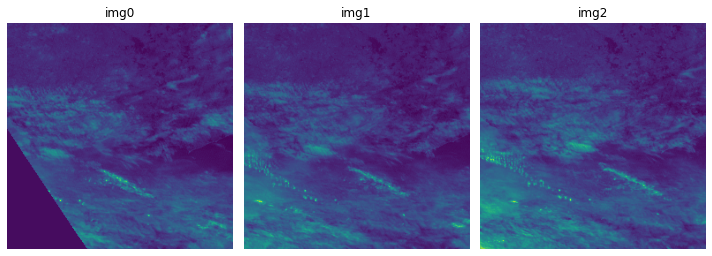

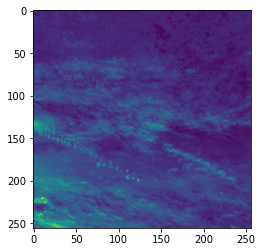

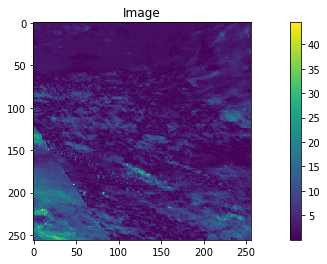

In [125]:
n=18

visualization.show_image_list(in_frames[n],rows =1)
plt.imshow(out_frames[n,0])
plt.show()

visualization.show_images_diff(in_frames[n,0], out_frames[n,0])


In [ ]:
batch_size = 64
transformed_dataset = vaporwaveDataset(ims=X_train)
train_dl = DataLoader(transformed_dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [2]:
def main_test(model_instance, dl_sw):
    predict_horizon = 10
    error_list_rmse =[]
    error_list_ssim = []

    per_predict_time= []
    eval_time = []
    cmv_predict_time = []
    
    for idx, samples in enumerate(dl_sw):

        if idx%50 == 0:
           print(idx)
        
        #predict depending on model
        if (isinstance(model_instance, model.Persistence)):
            start = time.time()
            predictions, prediction_ts = model_instance.predict(
                                    samples['images'][1], 
                                    samples['time_stamps'][1], 
                                    predict_horizon)
            end = time.time()
            per_predict_time.append(end-start)
            dynamic_window = False
        elif (isinstance(model_instance, model.Cmv)):
            start = time.time()
            predictions , cmv_ts = model_instance.predict(
                                    imgi=samples['images'][0, :, :], 
                                    imgf=samples['images'][1, :, :],
                                    imgf_ts = samples['time_stamps'][1], 
                                    period=10*60, delta_t=10*60, 
                                    predict_horizon=predict_horizon) 
            end = time.time()
            cmv_predict_time.append(end-start)
            dynamic_window = True

        #evaluate
        start = time.time()
        #evaluate sin tomar encuenta cosangs
        predict_errors_rmse = evaluate.evaluate_image(
                                                predictions = predictions, 
                                                gt = samples['images'][1:], 
                                                gt_ts = samples['time_stamps'][1:],
                                                metric='RMSE', dynamic_window=dynamic_window,
                                                evaluate_day_pixels = True)
        error_list_rmse.append(predict_errors_rmse)
        end = time.time()
        eval_time.append(end-start)
        #evaluate tomando en cuenta cosangs
        predict_errors_ssim = evaluate.evaluate_image(
                                                predictions = predictions, 
                                                gt = samples['images'][1:], 
                                                gt_ts = samples['time_stamps'][1:],
                                                metric='SSIM', dynamic_window=dynamic_window,
                                                evaluate_day_pixels = True)
        error_list_ssim.append(predict_errors_ssim)
    print('persistence predict time: ', np.sum(per_predict_time))
    print('cmv predict time: ', np.sum(cmv_predict_time))
    print('evaluation time: ', np.sum(eval_time))
    return error_list_rmse , error_list_ssim

predict_horizon = 10

dataset_sw = data.SatelliteImagesDatasetSW(root_dir = 'data/images/dia_305', 
                                           window = predict_horizon+2,
                                           transform = preprocessing.CropImage(3))
dl_sw = DataLoader(dataset_sw, batch_size=1, collate_fn=data.collate_fn_sw)


#cmv = model.Cmv2()
#blurredCMV = model.Cmv2(kernel_size=(21,21))
persistence = model.Persistence()
blurredP = model.BlurredPersistence( kernel_size=(51,51) )

print('Predicting blurred persistence')
error_list_bp_rmse, error_list_bp_ssim = main_test(blurredP,dl_sw)
print('Predicting Persistence')
error_list_p_rmse,error_list_p_ssim = main_test(persistence,dl_sw)
# print('Predicting Blurred CMV') 
# error_list_bp,error_list_bp_day = main_test(blurredCMV,dl_sw)

error_array_bp_rmse = np.array(error_list_bp_rmse)
error_array_bp_ssim = np.array(error_list_bp_ssim)
error_array_p_rmse = np.array(error_list_p_rmse)
error_array_p_ssim = np.array(error_list_p_ssim)

#print('CMV predicted ', error_array_cmv.shape[1],  'images for' , error_array_cmv.shape[0], 'images')
#print('Persistence predicted ', error_array_p.shape[1], 'images for' , error_array_p.shape[0],'images')
#print('Blurred Persistence predicted ', error_array_bp.shape[1], 'images for' , error_array_bp.shape[0], 'images')

Predicting blurred persistence
0
50
100
persistence predict time:  17.87904453277588
cmv predict time:  0.0
evaluation time:  108.1070556640625
Predicting Persistence
0
50
100
persistence predict time:  3.771155834197998
cmv predict time:  0.0
evaluation time:  101.43221616744995
